In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict

In [2]:
def softmax(a):
    # np.exp(a): (180, 3)
    # np.sum(np.exp(a), axis=1): (180,)
    return (np.exp(a).T / np.sum(np.exp(a), axis=1)).T

def softmax_prevent_overflow(a):
    y = np.empty(a.shape)
    for n in range(a.shape[0]):
        for k in range(a.shape[1]):
            y[n, k] = 1 / np.sum(np.exp(a[n, :] - a[n, k]))
    return y

In [3]:
class LogisticModal:
    def __init__(self, stop_critirion=35, stop_epoch=50):
        self.stop_critirion = stop_critirion
        self.stop_epoch = stop_epoch
        self.weight = 0
        self.classes = {}
    
    def input2class(self, x, t):
        classes = defaultdict(lambda: [])
        target = np.argmax(train_t, axis=1)

        for n in range(train_x.shape[0]): 
            classes[target[n]].append(train_x[n])

        for _class in classes.keys():
            classes[_class] = np.array(classes[_class])

        self.classes = classes
    
    def train(self, x, t):
        error_list = []
        accuracy_list = []
        weight_list = []
        
        w = np.zeros([train_t.shape[1], train_x.shape[1]])
        error = float('Inf')
        epoch = 1
        
        while 1:
            a = x.dot(w.T)
#             y = softmax(a)
            y = softmax_prevent_overflow(a)
            error = self.cross_entropy_error(y, t)
            error_list.append(error)
            accuracy_list.append(self.hit_accuracy(y, t))
            weight_list.append(w)
            
            if error < self.stop_critirion or math.isnan(error) or epoch>self.stop_epoch:
                error_list.pop()
                accuracy_list.pop()
                weight_list.pop()
                break

            H_inv = np.linalg.inv(self.cross_entropy_error_dev2(train_x, y))
            # (3,3,7,7) (3,7) =>(3,7)
            w -= np.tensordot(H_inv, self.cross_entropy_error_dev1(train_x, y, train_t), axes=([1, 3], [0, 1]))*0.01
            epoch += 1
        
        self.weight = weight_list[-1]
        return error_list, accuracy_list
            
    def hit_accuracy(self, y, t):
        y_class = np.argmax(y, axis=1)
        t_class = np.argmax(t, axis=1)
        return np.count_nonzero((y_class-t_class) == 0) / y_class.shape[0]

    def predict(self, x):
        return np.argmax(softmax_prevent_overflow(x.dot(self.weight.T)), axis=1)
    
    def cross_entropy_error(self, y, t): 
        return -np.sum(t * np.log(y))

    def cross_entropy_error_dev1(self, x, y, t): 
        return (y-t).T.dot(x)

    def cross_entropy_error_dev2(self, x, y): 
        # reference: PRML 4.110 p.210
        def get_R(y, k, j):
            return np.diag(y[:, k] * (np.eye(y.shape[1])[k, j]-y[:, j]))
        K = y.shape[1]
        M = x.shape[1]
        H = np.zeros([K, K, M, M])
            
        for k in range(K):
            for j in range(K):
                R = get_R(y, k, j)
                # (7,180) (180,180) (180,7) => (7,7)
                H[j, k] = x.T.dot(R).dot(x)
        
        return H

In [4]:
train_data = pd.read_csv("data/train.csv", header=None)
test_data = pd.read_csv("data/test.csv", header=None)

train_x = train_data.iloc[:, 3:].values
train_t = train_data.iloc[:, 0:3].values
test_x = test_data.values

In [5]:
LM = LogisticModal()
error_list, accuracy_list = LM.train(train_x, train_t)
LM.input2class(train_x, train_t)

# 1. Set the initial w to be zero, and show the learning curve of E(w) and the accuracy of classification versus the number of epochs until convergence of training data.

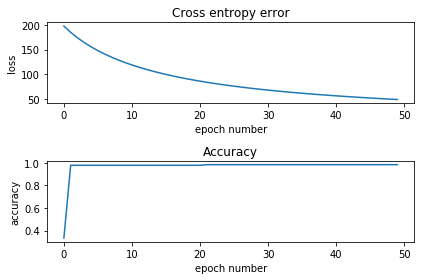

In [6]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(error_list)
ax[0].set_title('Cross entropy error')
ax[0].set_xlabel('epoch number')
ax[0].set_ylabel('loss')

ax[1].plot(accuracy_list)
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epoch number')
ax[1].set_ylabel('accuracy')
plt.tight_layout()
plt.show()

# 2. Show the classification result of test data.

In [7]:
LM.predict(test_x)

array([2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0])

# 3. Please plot the distribution (or histogram) of the variable in each dimension of training data and map different colors to each class.


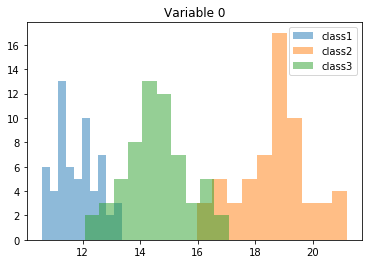

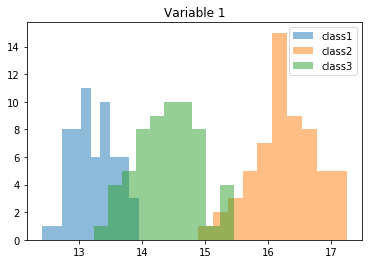

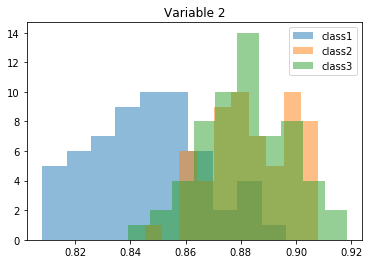

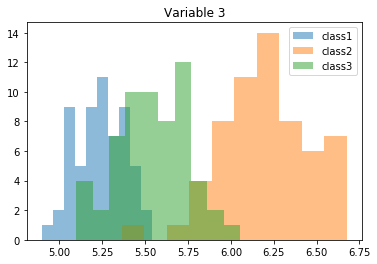

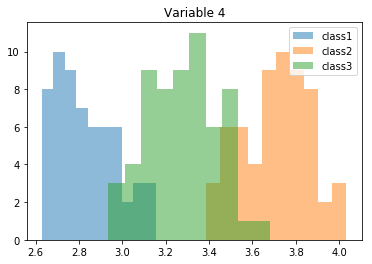

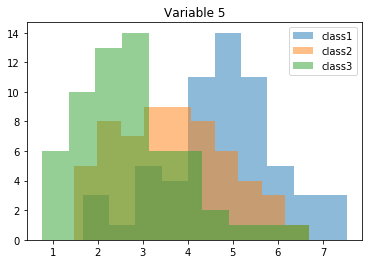

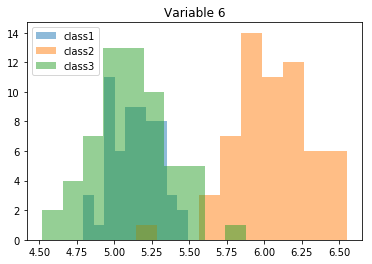

In [8]:
for m in range(train_x.shape[1]):
    for _class in LM.classes.keys():
        plt.hist(LM.classes[_class][:, m], alpha=0.5)
    labels= ['class1', 'class2', 'class3']
    plt.legend(labels)
    plt.title('Variable %d' % m)
    plt.show()

#  4. Explain that how do you know the model you trained is on the way to global minimum.

從E(w)的learning curve可以看出，error持續下降，另外由於error function是convex，所以只要learning rate夠小，可以持續往global minimum converge。一開始，我只有設定stop_critirion的參數以及learning rate=0.01，但一旦訓練時超過global minimum，error就會由原本漸漸變小，但是達某次epoch後，error會往上升。所以可以看出我的model有往global minimum訓練。

另外，以對training data的分類正確率也能看出正確率達98%，但也有可能會產生overfit的現象。

# 5. Please choose a pair of the most contributive variables and plot the samples in training data via 2D graph.


In [9]:
from itertools import combinations

most_contri_var = (0, 1)
error_min = float('Inf')

M = 7
K = 3

var_pairs = list(combinations(range(0, M), 2))
for var1, var2 in var_pairs:
   
    train_y = train_data.iloc[:, 0:3].values
    train_x = train_data.iloc[:, [var1+K, var2+K]].values

    LM = LogisticModal()
    error_list, accuracy_list = LM.train(train_x, train_t)

    if error_list[-1] < error_min: 
        error_min = error_list[-1]
        most_contri_var = (var1, var2)

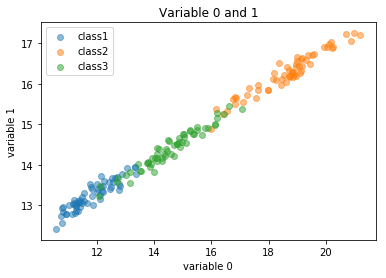

In [10]:
train_x = train_data.iloc[:, [most_contri_var[0]+K, most_contri_var[1]+K]].values
train_t = train_data.iloc[:, 0:3].values
    
LM = LogisticModal()
LM.input2class(train_x, train_t)

for _class in LM.classes.keys():
    plt.scatter(LM.classes[_class][:, 0], LM.classes[_class][:, 1], alpha=0.5)

labels= ['class1', 'class2', 'class3']
plt.legend(labels)
plt.title('Variable %d and %d' % (most_contri_var[0], most_contri_var[1]))
plt.xlabel('variable %d' % most_contri_var[0])
plt.ylabel('variable %d' % most_contri_var[1])
plt.show()

# 6. Use the variables you choose in (5) and redo (1) and (2).

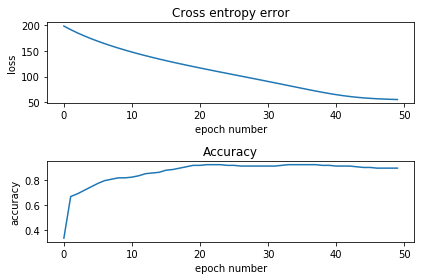

In [11]:
train_x = train_data.iloc[:, [most_contri_var[0]+K, most_contri_var[1]+K]].values
train_t = train_data.iloc[:, 0:3].values
test_x = test_data.iloc[:, [most_contri_var[0]+K, most_contri_var[1]+K]].values

LM = LogisticModal()
error_list, accuracy_list = LM.train(train_x, train_t)
LM.input2class(train_x, train_t)

fig, ax = plt.subplots(2, 1)
ax[0].plot(error_list)
ax[0].set_title('Cross entropy error')
ax[0].set_xlabel('epoch number')
ax[0].set_ylabel('loss')

ax[1].plot(accuracy_list)
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epoch number')
ax[1].set_ylabel('accuracy')
plt.tight_layout()
plt.show()

In [12]:
LM.predict(test_x)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
# reference PRML 4.1.6
# reference http://goelhardik.github.io/2016/10/04/fishers-lda/

class Fisher():
    def  __init__(self, dim_num=2):
        self.classes = {}
        self.dim_num = dim_num
        
    def input2class(self, x, t):
        classes = defaultdict(lambda: [])
        target = np.argmax(train_t, axis=1)

        for n in range(train_x.shape[0]): 
            classes[target[n]].append(train_x[n])

        for _class in classes.keys():
            classes[_class] = np.array(classes[_class])
        
        self.classes = classes
    
    def fit(self, x, t):
        overall_mean = np.mean(x, axis=0)
        within_class_mean = np.zeros((t.shape[1], x.shape[1]))
        for _class in self.classes.keys():
            within_class_mean[_class] = np.mean(self.classes[_class], axis=0)
        
        # between class covariance matrix D*D
        Sb = np.zeros((x.shape[1], x.shape[1]))
        for _class in self.classes.keys():
#             Sb += len(self.classes[_class])*np.outer((within_class_mean[_class] - overall_mean), (within_class_mean[_class] - overall_mean))
            tmp = (within_class_mean[_class]-overall_mean).reshape((1, 7))
            Sb += len(self.classes[_class]) * (tmp.T.dot(tmp))
        
        # within class covariance matrix D*D
        Sw = np.zeros((x.shape[1], x.shape[1]))
        for _class in self.classes.keys():
            tmp = (x-within_class_mean[_class])
            Sw += tmp.T.dot(tmp)
        
        eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
        eiglist = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]
        eiglist = sorted(eiglist, key = lambda x : -x[0])

        w = np.array([eiglist[i][1] for i in range(self.dim_num)])
        return w

# 7.  Use the Fisher’s linear discriminant (or the linear discriminant analysis) in Section 4.1 to project the data on a two-dimensional (2D) space and plot the training samples in a 2D graph.


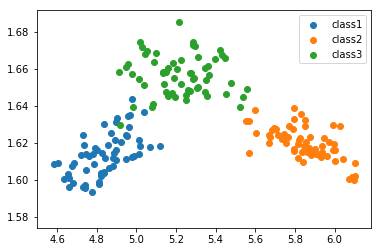

In [14]:
train_data = pd.read_csv("data/train.csv", header=None)
test_data = pd.read_csv("data/test.csv", header=None)

train_x = train_data.iloc[:, 3:].values
train_t = train_data.iloc[:, 0:3].values
test_x = test_data.values

LDA = Fisher()
LDA.input2class(train_x, train_t)
w = LDA.fit(train_x, train_t)

for _class in LDA.classes.keys():
    project = LDA.classes[_class].dot(w.T)
    plt.scatter(project[:, 0], project[:, 1])

labels= ['class1', 'class2', 'class3']
plt.legend(labels)
plt.show()

# sklearn

In [15]:
# import pandas as pd
# import numpy as np
# from sklearn import preprocessing, linear_model

# # 建立模型
# logistic_regr = linear_model.LogisticRegression()
# logistic_regr.fit(train_x, np.argmax(train_t, axis=1))

# survived_predictions = logistic_regr.predict(test_x)
# print(survived_predictions)